<a href="https://colab.research.google.com/github/biepoonpoon/nbamvpprediction/blob/main/mvpprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/biepoonpoon/nbamvpprediction.git

Cloning into 'nbamvpprediction'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 16 (delta 6), reused 12 (delta 4), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [2]:
from nbamvpprediction.NBAStatData import NBAStatData
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [3]:
#ใช้ข้อมูลตังแต่ ss 1979-1980 ถึง 2019-2020

year_start = 1980
year_stop = 2020

nba = NBAStatData(year_start,year_stop,False)

In [4]:
award_share = nba.mvp_votingshare()

In [5]:
all_player_stat = pd.concat(award_share, ignore_index=True)
all_player_stat.head()

,Player,WIN%,G/TOT,MP/G,PTS,AST,TRB,STL,BLK,PF,FGA,3PA,FTA,FG%,3P%,FT%,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,PER,BPM,TS%,USG%,WS,WS/48,YEAR,Voting_Share
0,Kareem Abdul-Jabbar,0.731707,1.000000,38.329268,2034,371,886,81,280,216,1383,1,476,0.604,0.000,0.765,7.2,22.2,15.4,16.5,1.2,4.6,15.7,25.3,7.2,0.639,24.1,14.8,0.227,1980,0.665
1,Tom Abernethy,0.292683,0.817073,18.238806,362,87,191,35,12,118,318,1,82,0.481,0.000,0.683,5.4,12.0,8.6,9.3,1.4,0.6,9.9,11.0,-1.2,0.511,13.3,2.0,0.080,1980,0.000
2,Alvan Adams,0.670732,0.914634,28.906667,1118,322,609,108,55,237,875,2,236,0.531,0.000,0.797,8.2,22.4,15.4,21.6,2.3,1.4,18.2,19.2,3.6,0.571,21.9,7.0,0.155,1980,0.000
3,Tiny Archibald,0.743902,0.975610,35.800000,1131,671,197,106,10,218,794,18,435,0.482,0.222,0.830,2.3,5.3,3.8,30.2,1.7,0.2,19.7,15.3,1.1,0.574,17.0,8.9,0.148,1980,0.009
4,Dennis Awtrey,0.365854,0.317073,21.538462,86,40,115,12,15,66,60,0,50,0.450,0.000,0.640,6.0,16.9,11.5,9.0,1.0,1.5,24.8,7.4,-1.4,0.524,7.9,0.6,0.053,1980,0.000


In [6]:
mvp_candidate = all_player_stat.loc[all_player_stat["Voting_Share"] > 0]
mvp_candidate.head()

,Player,WIN%,G/TOT,MP/G,PTS,AST,TRB,STL,BLK,PF,FGA,3PA,FTA,FG%,3P%,FT%,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,PER,BPM,TS%,USG%,WS,WS/48,YEAR,Voting_Share
0,Kareem Abdul-Jabbar,0.731707,1.00000,38.329268,2034,371,886,81,280,216,1383,1,476,0.604,0.000,0.765,7.2,22.2,15.4,16.5,1.2,4.6,15.7,25.3,7.2,0.639,24.1,14.8,0.227,1980,0.665
3,Tiny Archibald,0.743902,0.97561,35.800000,1131,671,197,106,10,218,794,18,435,0.482,0.222,0.830,2.3,5.3,3.8,30.2,1.7,0.2,19.7,15.3,1.1,0.574,17.0,8.9,0.148,1980,0.009
17,Larry Bird,0.743902,1.00000,36.036585,1745,370,852,143,53,279,1463,143,360,0.474,0.406,0.836,8.3,23.6,16.0,18.5,2.3,1.0,14.0,20.5,4.5,0.538,25.3,11.2,0.182,1980,0.068
84,Julius Erving,0.719512,0.95122,36.051282,2100,355,576,170,140,208,1614,20,534,0.519,0.200,0.787,8.6,12.9,10.9,21.4,2.8,2.7,13.3,25.4,7.6,0.568,30.3,12.5,0.213,1980,0.143
97,George Gervin,0.500000,0.95122,37.615385,2585,202,403,110,79,208,1940,102,593,0.528,0.314,0.852,5.7,8.9,7.3,11.0,1.6,1.4,10.3,24.0,3.9,0.587,31.7,10.6,0.173,1980,0.086


## กำหนดปัญหา

การที่จะทำนายผลผู้เล่นที่มีโอกาศจะได้ชนะรางวัล MVP นั้น จำเป็นต้องใช้คอลัมน์  Voting_Share เป็น target ในการวิเคราะห์ จึงได้เลือกใช้ regression model มาแก้ปัญหานี้ โดยแต่ละ column ของข้อมูลจะมีผลต่อคะแนนของ target ของเรา

โดย Voting_Share นั้นจะมีค่าอยู่ที่ 0-1 แสดงถึงคะแนนที่โหวตให้กับผู้เล่นแต่ละคน แต่จาก histrogram ด้านล่างจะเห็นว่า ข้อมูลนั้นไปกองกันที่ 0.0-0.2 ซึ่งแาจเป็นปัญหาในการสร้างโมเดล




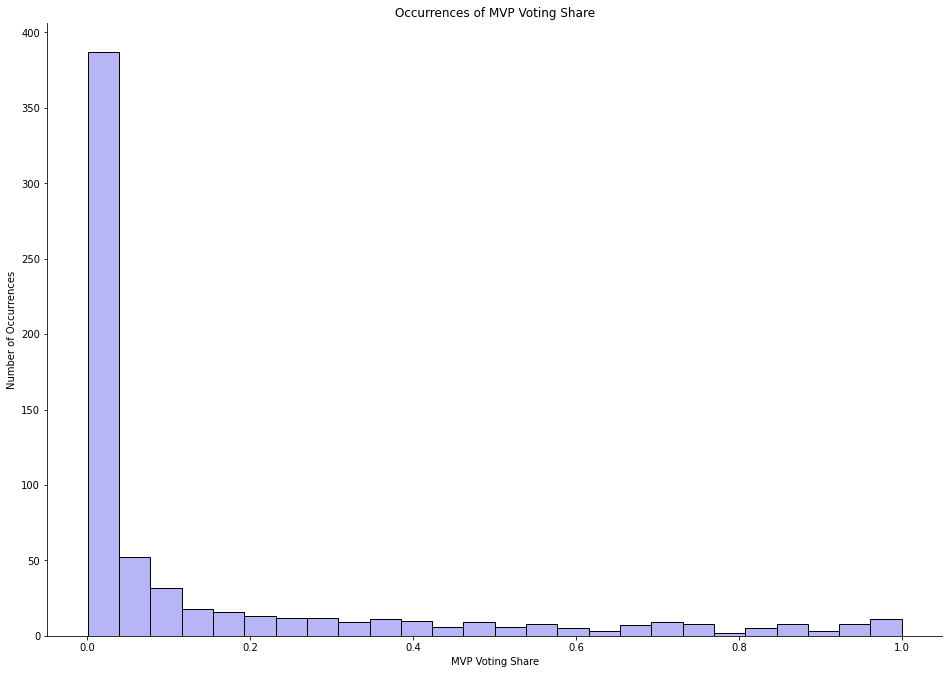

In [7]:
hist = sns.displot(data = mvp_candidate["Voting_Share"], color="#A09CF3")
hist.set(xlabel = "MVP Voting Share", ylabel= "Number of Occurrences")
plt.title('Occurrences of MVP Voting Share')
hist.fig.set_figwidth(15)
hist.fig.set_figheight(10)